In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os

In [62]:
import pandas as pd
import os

def load_and_process_csv(path):
    # List to hold individual DataFrames with hierarchical indices
    dfs = []
    
    # List all CSV files in the given directory
    for filename in os.listdir(path):
        if filename.endswith('.csv'):
            # Split the filename by '_'
            parts = filename.split('_')
            
            if len(parts) ==9:
                start_dim =4
            else:
                start_dim =3
            # Extract particle and jet information
            particle_geom = parts[start_dim]
            particle_dim = int(parts[start_dim+1])
            jet_geom = parts[start_dim+2]
            jet_dim = int(parts[start_dim+3])
            
            # Load the CSV into a DataFrame
            df = pd.read_csv(os.path.join(path, filename))
            
            # Create a MultiIndex for this DataFrame
            index_tuples = [(particle_geom, particle_dim, jet_geom, jet_dim)] * len(df)
            index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])
            
            # Assign the MultiIndex to the DataFrame
            df.index = index
            
            # Append the DataFrame to the list
            dfs.append(df)
    
    # Concatenate all DataFrames into one, maintaining the hierarchical index
    combined_df = pd.concat(dfs)
    
    return combined_df

In [73]:
import matplotlib.pyplot as plt

def plot_highest_accuracies(df, variable_to_vary, metric_column='acc', filter_values=None, acc_range = None):
    # Identify the columns that will remain constant
    remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    remaining_columns.remove(variable_to_vary)
    
    # If filtering values are provided, apply them to the DataFrame
    if filter_values:
        indexer = pd.IndexSlice
        for col, val in filter_values.items():
            df = df.loc[df.index.get_level_values(col) == val]

    # Group by the remaining columns and the variable_to_vary
    grouped = df.groupby(remaining_columns)
    
    # Plot each group
    plt.figure(figsize=(10, 6))
    for name, group in grouped:
        # Find the maximum accuracy for each unique value in the variable_to_vary column
        max_accuracy = group.groupby(variable_to_vary)[metric_column].max()
        
        # Plot the data
        plt.plot(max_accuracy.index, max_accuracy.values, marker='o', label=f"{name}")
    
    plt.xlabel(variable_to_vary)
    plt.ylabel('Highest Accuracy')
    plt.title(f'Highest Accuracies with respect to {variable_to_vary}')
    plt.legend(title=f'{" & ".join(remaining_columns)}', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    if acc_range is not None:
        plt.ylim(*acc_range)
    plt.show()


In [129]:
path = 'TopLandscape_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df, variable_to_vary='jet_dim', filter_values=filter_values, acc_range = [0.928,0.934])

FileNotFoundError: [Errno 2] No such file or directory: 'TopLandscape_performance_summary'

In [130]:
path = 'TopLandscape_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df, variable_to_vary='particle_dim', filter_values=filter_values)

FileNotFoundError: [Errno 2] No such file or directory: 'TopLandscape_performance_summary'

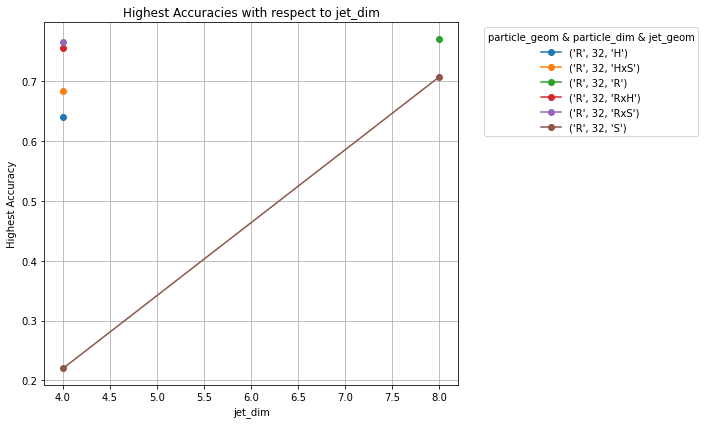

In [124]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df, variable_to_vary='jet_dim',filter_values=filter_values)

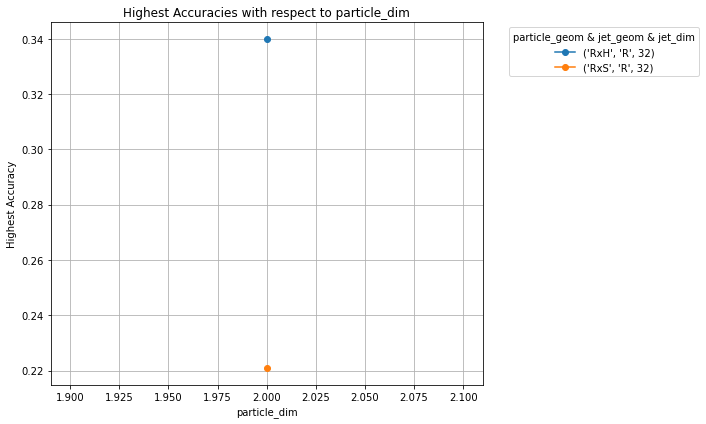

In [125]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 32
}
plot_highest_accuracies(combined_df, variable_to_vary='particle_dim',filter_values=filter_values)

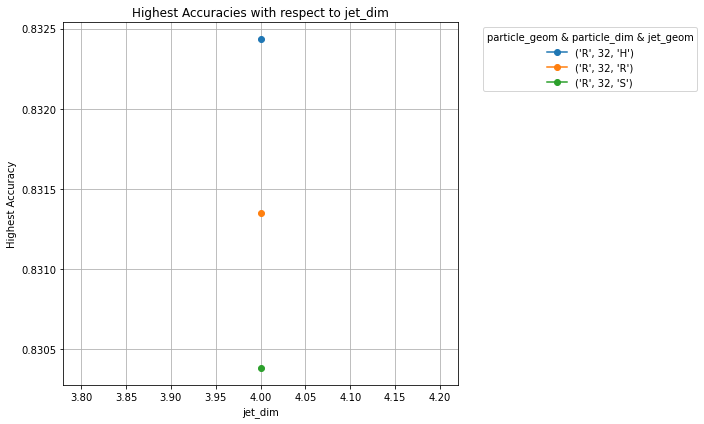

In [127]:
path = 'QuarkGluon_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df, variable_to_vary='jet_dim',filter_values=filter_values)

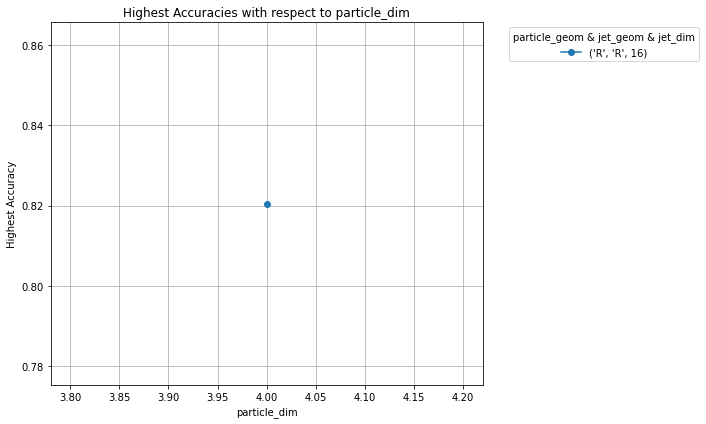

In [128]:
path = 'QuarkGluon_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df, variable_to_vary='particle_dim', filter_values=filter_values)